# **Import**

In [3]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# !pip install keras-tcn
from tcn import TCN

from tensorflow.keras.callbacks import EarlyStopping

# **Data Load**

In [5]:
cd /content/drive/MyDrive/[Projects]/Kaggle/NASA 터보팬 제트 엔진의 잔존 수명 예측 및 예지보전 방안/Data

/content/drive/MyDrive/[Projects]/Kaggle/NASA 터보팬 제트 엔진의 잔존 수명 예측 및 예지보전 방안/Data


In [6]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = [f's_{i + 1}' for i in range(21)]
col_names = index_names + setting_names + sensor_names

train_df = pd.read_csv('./train_FD004.csv')

In [7]:
max_cycle = train_df.groupby('unit_number')['time_cycles'].max().reset_index()
max_cycle.columns = ['unit_number', 'max_cycle']

train_df = train_df.merge(max_cycle, on='unit_number', how='left')

train_df['RUL'] = train_df['max_cycle'] - train_df['time_cycles']

# **Model**

In [8]:
def create_sequences(df, sensor_names, window_size=30):
    x, y = [], []
    scaler = MinMaxScaler()
    df_scaled = df.copy()
    df_scaled[sensor_names] = scaler.fit_transform(df[sensor_names])

    for unit in df_scaled['unit_number'].unique():
        unit_data = df_scaled[df_scaled['unit_number'] == unit]
        sensors = unit_data[sensor_names].values
        rul = unit_data['RUL'].values

        for i in range(len(unit_data) - window_size):
            x.append(sensors[i:i+window_size])
            y.append(rul[i+window_size])

    return np.array(x), np.array(y)

In [9]:
features = [
    'unit_number', 'time_cycles',
    's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10',
    's_11','s_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19',
    's_20', 's_21', 'RUL'
]
train_df = train_df[features]
train_df.head()

,unit_number,time_cycles,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,445.00,549.68,1343.43,1112.93,3.91,5.70,137.36,2211.86,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,320
1,1,2,491.19,606.07,1477.61,1237.50,9.35,13.61,332.10,2323.66,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,319
2,1,3,445.00,548.95,1343.12,1117.05,3.91,5.69,138.18,2211.92,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,318
3,1,4,445.00,548.70,1341.24,1118.03,3.91,5.70,137.98,2211.88,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,317
4,1,5,462.54,536.10,1255.23,1033.59,7.05,9.00,174.82,1915.22,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,316


## **LSTM**

In [10]:
window_size = 30
sensor_names = [c for c in train_df.columns if 's_' in c]

x, y = create_sequences(train_df, sensor_names, window_size)

unit_ids = train_df['unit_number'].unique()
unit_groups = [unit_ids[i:i+24] for i in range(0, len(unit_ids), 24)]

In [11]:
results = []
for fold_idx, val_units in enumerate(unit_groups, 1):
    print(f"\n=== Fold {fold_idx}: val_units = {val_units} ===")

    # train/val split (unit 단위)
    train_units = [u for u in unit_ids if u not in val_units]
    train_mask = train_df['unit_number'].isin(train_units)
    val_mask = train_df['unit_number'].isin(val_units)

    # 각 set에 대해 시퀀스 생성
    x_train, y_train = create_sequences(train_df[train_mask], sensor_names, window_size)
    x_val, y_val = create_sequences(train_df[val_mask], sensor_names, window_size)

    input_shape = (x_train.shape[1], x_train.shape[2])

    lstm_model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=False),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')

    lstm_model.fit(
        x_train,
        y_train,
        epochs=30,
        batch_size=64,
        validation_data=(x_val, y_val),
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=0
    )

    lstm_pred = lstm_model.predict(x_val)
    lstm_rmse = np.sqrt(mean_squared_error(y_val, lstm_pred))
    lstm_mae = mean_absolute_error(y_val, lstm_pred)

    results.append({
        'fold': fold_idx,
        'val_units': val_units.tolist(),
        'LSTM_RMSE': lstm_rmse,
        'LSTM_MAE': lstm_mae,
    })
    print(f"RMSE: {lstm_rmse:.3f}, MAE: {lstm_mae:.3f}")


=== Fold 1: val_units = [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] ===
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
RMSE: 49.385, MAE: 38.274

=== Fold 2: val_units = [25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] ===
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RMSE: 48.159, MAE: 36.652

=== Fold 3: val_units = [49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] ===
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RMSE: 65.589, MAE: 49.754

=== Fold 4: val_units = [73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96] ===
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RMSE: 50.032, MAE: 37.540

=== Fold 5: val_units = [ 97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120] ===
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RMSE: 73.666, MAE: 50.219

=== Fold 6: val_units = [121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138
 139 140 141 142 143 144] =

In [12]:
results_df = pd.DataFrame(results)

print(results_df[['fold', 'LSTM_RMSE', 'LSTM_MAE',]])
print(results_df[['LSTM_RMSE', 'LSTM_MAE',]].mean())

    fold  LSTM_RMSE   LSTM_MAE
0      1  49.385291  38.273521
1      2  48.159053  36.651794
2      3  65.589376  49.754303
3      4  50.031665  37.540287
4      5  73.666428  50.219265
5      6  55.330389  37.970093
6      7  58.237048  44.108593
7      8  91.350186  65.465424
8      9  55.144619  39.277378
9     10  58.658171  42.866554
10    11  60.943467  47.891426
LSTM_RMSE    60.590518
LSTM_MAE     44.547149
dtype: float64


## **TCN**

In [13]:
window_size = 30
sensor_names = [c for c in train_df.columns if 's_' in c]

x, y = create_sequences(train_df, sensor_names, window_size)

unit_ids = train_df['unit_number'].unique()
unit_groups = [unit_ids[i:i+24] for i in range(0, len(unit_ids), 24)]

In [14]:
results = []
for fold_idx, val_units in enumerate(unit_groups, 1):
    print(f"\n=== Fold {fold_idx}: val_units = {val_units} ===")

    train_units = [u for u in unit_ids if u not in val_units]
    train_mask = train_df['unit_number'].isin(train_units)
    val_mask = train_df['unit_number'].isin(val_units)

    x_train, y_train = create_sequences(train_df[train_mask], sensor_names, window_size)
    x_val, y_val = create_sequences(train_df[val_mask], sensor_names, window_size)

    input_shape = (x_train.shape[1], x_train.shape[2])

    tcn_model = Sequential([
        TCN(
            input_shape=(window_size, len(sensor_names)),
            nb_filters=64,
            kernel_size=3,
            dilations=[1, 2, 4, 8],
            dropout_rate=0.1,
            activation='relu',
            use_skip_connections=True,
            return_sequences=False
        ),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    tcn_model.compile(optimizer='adam', loss='mse')

    tcn_model.fit(
        x_train,
        y_train,
        epochs=30,
        batch_size=64,
        validation_data=(x_val, y_val),
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=0
    )

    tcn_pred = tcn_model.predict(x_val)
    tcn_rmse = np.sqrt(mean_squared_error(y_val, tcn_pred))
    tcn_mae = mean_absolute_error(y_val, tcn_pred)

    results.append({
        'fold': fold_idx,
        'val_units': val_units.tolist(),
        'TCN_RMSE': tcn_rmse,
        'TCN_MAE': tcn_mae
    })
    print(f"RMSE: {tcn_rmse:.3f}, MAE: {tcn_mae:.3f}")


=== Fold 1: val_units = [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] ===
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
RMSE: 44.638, MAE: 34.323

=== Fold 2: val_units = [25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] ===
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
RMSE: 48.225, MAE: 35.547

=== Fold 3: val_units = [49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] ===
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
RMSE: 63.108, MAE: 47.725

=== Fold 4: val_units = [73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96] ===
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
RMSE: 45.619, MAE: 33.416

=== Fold 5: val_units = [ 97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120] ===
164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
RMSE: 73.969, MAE: 45.991

=== Fold 6: val_units = [121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138
 139 140 141 142 143 144] =

In [15]:
results_df = pd.DataFrame(results)

print(results_df[['fold',  'TCN_RMSE', 'TCN_MAE']])
print(results_df[[ 'TCN_RMSE', 'TCN_MAE']].mean())

    fold   TCN_RMSE    TCN_MAE
0      1  44.637692  34.322990
1      2  48.224851  35.547302
2      3  63.107777  47.724533
3      4  45.619100  33.415936
4      5  73.969397  45.990993
5      6  54.713953  36.712444
6      7  55.864030  41.447159
7      8  90.380378  63.757599
8      9  53.867448  39.623165
9     10  59.458578  42.346016
10    11  55.219245  42.342003
TCN_RMSE    58.642041
TCN_MAE     42.111831
dtype: float64


# **Predict RUL**

In [16]:
# 전체 데이터로 시퀀스 생성
x_all, y_all = create_sequences(train_df, sensor_names, window_size)

# LSTM 최종 모델 학습
final_lstm = Sequential([
    LSTM(64, input_shape=(x_all.shape[1], x_all.shape[2]), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])
final_lstm.compile(optimizer='adam', loss='mse')
final_lstm.fit(x_all, y_all, epochs=30, batch_size=64, verbose=0)

# TCN 최종 모델 학습
final_tcn = Sequential([
    TCN(input_shape=(x_all.shape[1], x_all.shape[2]),
        nb_filters=64, kernel_size=3, dilations=[1,2,4,8],
        dropout_rate=0.1, activation='relu', use_skip_connections=True),
    Dense(32, activation='relu'),
    Dense(1)
])
final_tcn.compile(optimizer='adam', loss='mse')
final_tcn.fit(x_all, y_all, epochs=30, batch_size=64, verbose=0)

# 전체 데이터에 대한 예측
lstm_pred_all = final_lstm.predict(x_all)
tcn_pred_all = final_tcn.predict(x_all)

1681/1681 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1681/1681 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


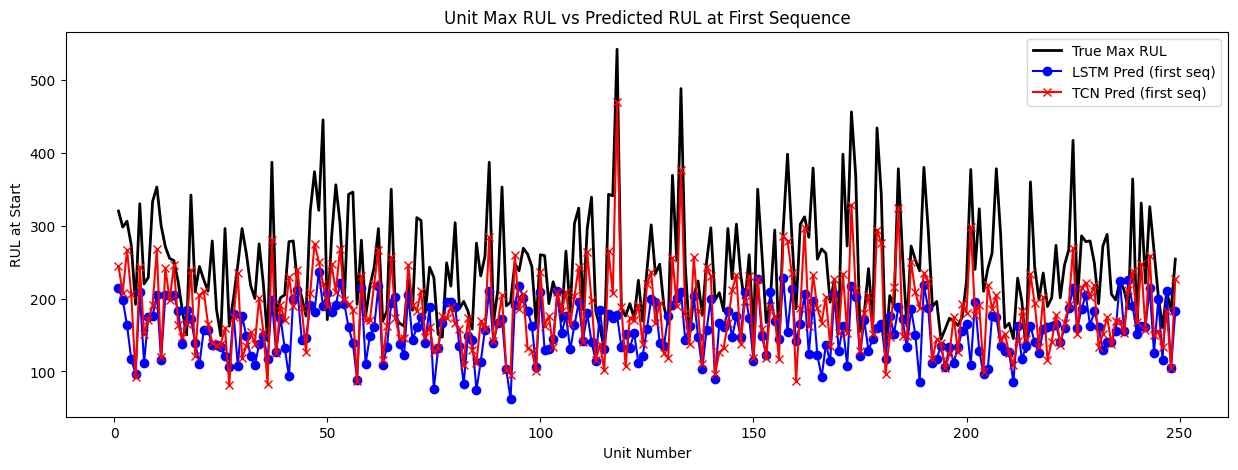

In [17]:
unit_ids = train_df['unit_number'].unique()

true_max_rul = []
lstm_rul_start = []
tcn_rul_start = []

start_idx = 0
for unit in unit_ids:
    unit_len = len(train_df[train_df['unit_number'] == unit])

    max_rul = train_df[train_df['unit_number'] == unit]['RUL'].max()
    true_max_rul.append(max_rul)

    first_seq_idx = start_idx
    lstm_rul_start.append(lstm_pred_all[first_seq_idx][0])
    tcn_rul_start.append(tcn_pred_all[first_seq_idx][0])

    start_idx += unit_len - window_size

df_max = pd.DataFrame({
    'unit_number': unit_ids,
    'True_Max_RUL': true_max_rul,
    'LSTM_FirstSeq_RUL': lstm_rul_start,
    'TCN_FirstSeq_RUL': tcn_rul_start
})

plt.figure(figsize=(15,5))
plt.plot(df_max['unit_number'], df_max['True_Max_RUL'], label='True Max RUL', color='black', linewidth=2)
plt.plot(df_max['unit_number'], df_max['LSTM_FirstSeq_RUL'], label='LSTM Pred (first seq)', color='blue', marker='o')
plt.plot(df_max['unit_number'], df_max['TCN_FirstSeq_RUL'], label='TCN Pred (first seq)', color='red', marker='x')
plt.xlabel('Unit Number')
plt.ylabel('RUL at Start')
plt.title('Unit Max RUL vs Predicted RUL at First Sequence')
plt.legend()
plt.show()

# **Test**

In [18]:
test_df = pd.read_csv('./test_FD004.csv')
rul_df = pd.read_csv('./RUL_FD004.csv')

In [20]:
features = [
    'unit_number', 'time_cycles',
    's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10',
    's_11','s_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19',
    's_20', 's_21'
]
test_df = test_df[features]
test_df.head()

,unit_number,time_cycles,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,491.19,606.67,1481.04,1227.81,9.35,13.60,332.52,2323.67,...,313.03,2387.78,8048.98,9.2229,0.02,362,2324,100.00,24.31,14.7007
1,1,2,462.54,536.22,1256.17,1031.48,7.05,9.00,174.46,1915.21,...,163.61,2028.09,7863.46,10.8632,0.02,306,1915,84.93,14.36,8.5748
2,1,3,445.00,549.23,1340.13,1105.88,3.91,5.69,137.34,2211.93,...,129.98,2387.95,8071.13,9.3960,0.02,328,2212,100.00,10.39,6.4365
3,1,4,445.00,549.19,1339.70,1107.26,3.91,5.69,137.23,2211.89,...,129.48,2387.90,8078.89,9.3594,0.02,328,2212,100.00,10.56,6.2367
4,1,5,449.44,555.10,1353.04,1117.80,5.48,7.97,192.94,2222.71,...,181.82,2387.87,8057.83,9.3030,0.02,333,2223,100.00,14.85,8.9326


In [21]:
sensor_names = [c for c in test_df.columns if 's_' in c]
window_size = 30

def create_test_sequences(df, sensor_names, window_size):
    x_test, y_test = [], []
    scaler = MinMaxScaler()
    df_scaled = df.copy()
    df_scaled[sensor_names] = scaler.fit_transform(df[sensor_names])

    unit_max_rul = []

    for unit in df_scaled['unit_number'].unique():
        unit_data = df_scaled[df_scaled['unit_number'] == unit]
        sensors = unit_data[sensor_names].values
        rul = np.arange(len(unit_data)-1, -1, -1)  # Test set RUL: 마지막부터 1씩 감소

        # window_size 마지막 시퀀스만 사용 (혹은 sliding 가능)
        if len(unit_data) >= window_size:
            x_test.append(sensors[-window_size:])
            y_test.append(rul[-1])  # 마지막 시점 RUL
        else:
            # window_size보다 작은 경우 패딩 (앞쪽 반복)
            pad = np.repeat(sensors[0:1], window_size - len(unit_data), axis=0)
            x_test.append(np.vstack([pad, sensors]))
            y_test.append(rul[-1])

        unit_max_rul.append(rul[-1])

    return np.array(x_test), np.array(y_test), unit_max_rul

x_test_seq, y_test_seq, unit_max_rul = create_test_sequences(test_df, sensor_names, window_size)

In [22]:
lstm_pred_test = final_lstm.predict(x_test_seq)

lstm_rmse = np.sqrt(mean_squared_error(y_test_seq, lstm_pred_test))
lstm_mae = mean_absolute_error(y_test_seq, lstm_pred_test)
print(f"RMSE: {lstm_rmse:.3f}, MAE: {lstm_mae:.3f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
RMSE: 43.066, MAE: 31.774


In [23]:
tcn_pred_test = final_tcn.predict(x_test_seq)

tcn_rmse = np.sqrt(mean_squared_error(y_test_seq, tcn_pred_test))
tcn_mae = mean_absolute_error(y_test_seq, tcn_pred_test)
print(f"RMSE: {tcn_rmse:.3f}, MAE: {tcn_mae:.3f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
RMSE: 55.441, MAE: 42.897


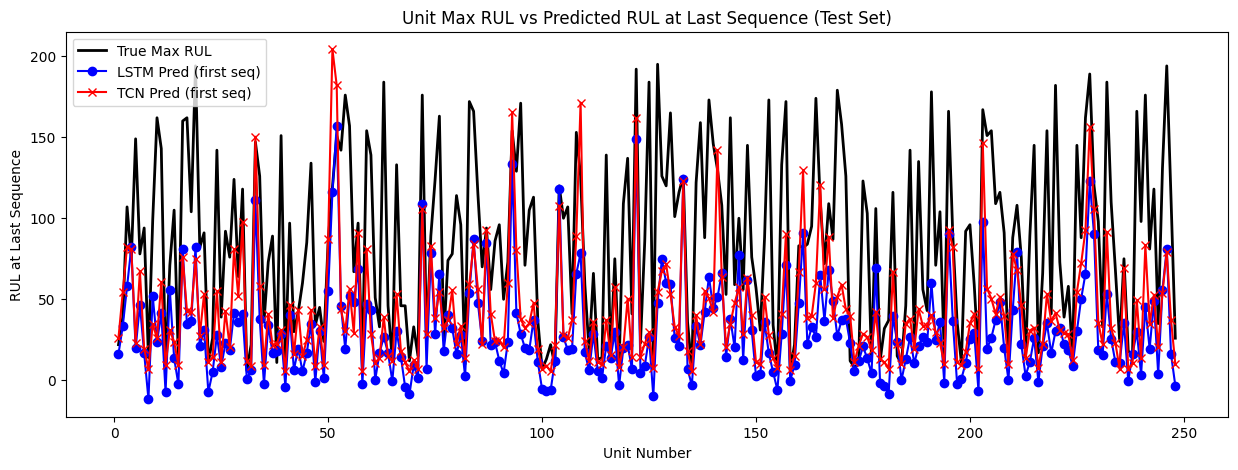

In [24]:
unit_ids = test_df['unit_number'].unique()

true_max_rul = rul_df['RUL'].values.tolist()  # Test set 실제 RUL
lstm_rul_start = []
tcn_rul_start = []

start_idx = 0
for unit in unit_ids:
    # unit별 시퀀스 개수
    unit_len = len(x_test_seq[start_idx:]) if len(x_test_seq[start_idx:]) == 1 else 1  # 마지막 시퀀스만 사용
    lstm_rul_start.append(lstm_pred_test[start_idx][0])
    tcn_rul_start.append(tcn_pred_test[start_idx][0])
    start_idx += unit_len

df_max = pd.DataFrame({
    'unit_number': unit_ids,
    'True_Max_RUL': true_max_rul,
    'LSTM_FirstSeq_RUL': lstm_rul_start,
    'TCN_FirstSeq_RUL': tcn_rul_start
})

plt.figure(figsize=(15,5))
plt.plot(df_max['unit_number'], df_max['True_Max_RUL'], label='True Max RUL', color='black', linewidth=2)
plt.plot(df_max['unit_number'], df_max['LSTM_FirstSeq_RUL'], label='LSTM Pred (first seq)', color='blue', marker='o')
plt.plot(df_max['unit_number'], df_max['TCN_FirstSeq_RUL'], label='TCN Pred (first seq)', color='red', marker='x')
plt.xlabel('Unit Number')
plt.ylabel('RUL at Last Sequence')
plt.title('Unit Max RUL vs Predicted RUL at Last Sequence (Test Set)')
plt.legend()
plt.show()